# Face Recognition Testing dengan InsightFace

Notebook ini untuk testing face detection dan recognition menggunakan InsightFace.

**Model yang tersedia:**
- `buffalo_l` (default): Akurasi tinggi, ~100MB
- `buffalo_sc`: Lebih kecil dan cepat, ~16MB (recommended untuk testing)

Model akan otomatis didownload saat pertama kali dijalankan.

In [2]:
"""
Test ArcFace dengan MobileFaceNet untuk Face Recognition
Model: buffalo_l (default model dari InsightFace)
"""
import cv2
import numpy as np
from insightface.app import FaceAnalysis
import matplotlib.pyplot as plt
from pathlib import Path

print("Initializing Face Recognition System...")
print("Model akan didownload otomatis jika belum ada (~100MB)")
print("Mohon tunggu...\n")

# Initialize FaceAnalysis dengan model default (buffalo_l)
# Model akan otomatis didownload ke ~/.insightface/models/
app = FaceAnalysis(
    providers=["CPUExecutionProvider"]
)

# Prepare model dengan detection size optimal untuk CPU
print("Loading model...")
app.prepare(ctx_id=0, det_size=(640, 640))
print("✓ Model loaded successfully!\n")

Initializing Face Recognition System...
Model akan didownload otomatis jika belum ada (~100MB)
Mohon tunggu...

download_path: C:\Users\risky/.insightface\models\buffalo_l


100%|██████████| 281857/281857 [02:16<00:00, 2064.31KB/s]



Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\risky/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\risky/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\risky/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\risky/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\risky/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
A

In [8]:
"""
Test 1: Face Detection dan Embedding Extraction
"""
# Load test image
img_path = r"C:\Users\risky\OneDrive\Dokumen\Project Fastwork\face_recog_makan\asyam.jpg"
img = cv2.imread(img_path)

if img is None:
    print(f"Error: Tidak dapat membaca image dari {img_path}")
    print("Pastikan file image ada atau gunakan path yang benar")
else:
    # Detect faces and extract embeddings
    faces = app.get(img)
    
    print(f"Jumlah wajah terdeteksi: {len(faces)}")
    
    for idx, face in enumerate(faces):
        print(f"\nWajah {idx + 1}:")
        print(f"  - Bounding box: {face.bbox}")
        print(f"  - Confidence: {face.det_score:.4f}")
        print(f"  - Embedding shape: {face.embedding.shape}")  # Should be (512,) untuk ArcFace
        print(f"  - Embedding sample: {face.embedding[:5]}")  # Show first 5 values

Jumlah wajah terdeteksi: 1

Wajah 1:
  - Bounding box: [ 321.85095  459.6724   774.1662  1102.4032 ]
  - Confidence: 0.9042
  - Embedding shape: (512,)
  - Embedding sample: [ 0.4217829   0.11650933 -0.06884804  1.305452    0.23195949]


c:\Users\risky\anaconda3\envs\face_recognition\lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


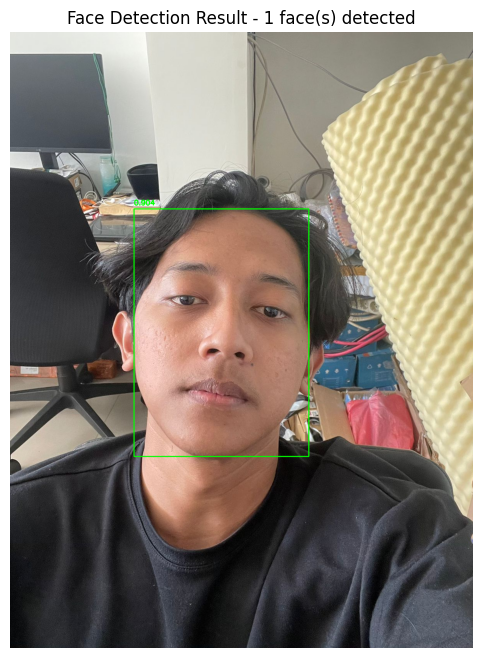

In [ ]:
"""
Test 2: Visualisasi Face Detection
"""
if img is not None and len(faces) > 0:
    img_display = img.copy()
    
    for face in faces:
        # Draw bounding box
        bbox = face.bbox.astype(int)
        cv2.rectangle(img_display, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        
        # Draw confidence score
        conf_text = f"{face.det_score:.3f}"
        cv2.putText(img_display, conf_text, (bbox[0], bbox[1]-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    # Convert BGR to RGB for matplotlib
    img_rgb = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)
    
    # Display
    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f'Face Detection Result - {len(faces)} face(s) detected')
    plt.show()
else:
    print("Tidak ada wajah terdeteksi atau image tidak valid")

In [14]:
"""
Test 3: Similarity Comparison antara 2 Wajah
Fungsi untuk membandingkan kesamaan wajah (untuk verifikasi)
"""
def cosine_similarity(emb1, emb2):
    """Hitung cosine similarity antara 2 embeddings"""
    return np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))

def compare_faces(img_path1, img_path2, threshold=0.4):
    """
    Bandingkan 2 wajah dari 2 image
    threshold: 0.4 untuk strict, 0.3 untuk lebih loose
    """
    # Load images
    img1 = cv2.imread(img_path1)
    img2 = cv2.imread(img_path2)
    
    if img1 is None or img2 is None:
        print("Error: Tidak dapat membaca salah satu image")
        return None
    
    # Get faces
    faces1 = app.get(img1)
    faces2 = app.get(img2)
    
    if len(faces1) == 0 or len(faces2) == 0:
        print("Error: Tidak ada wajah terdeteksi di salah satu image")
        return None
    
    # Get embeddings (ambil wajah pertama jika ada multiple faces)
    emb1 = faces1[0].embedding
    emb2 = faces2[0].embedding
    
    # Calculate similarity
    similarity = cosine_similarity(emb1, emb2)
    
    print(f"Similarity Score: {similarity:.4f}")
    print(f"Threshold: {threshold}")
    
    if similarity >= threshold:
        print(f"✓ MATCH - Kedua wajah adalah orang yang sama")
    else:
        print(f"✗ NO MATCH - Kedua wajah adalah orang yang berbeda")
    
    return similarity


img1 = r"C:\Users\risky\OneDrive\Dokumen\Project Fastwork\face_recog_makan\img1.jpg"
img2 = r"C:\Users\risky\OneDrive\Dokumen\Project Fastwork\face_recog_makan\img2.jpg"

# Contoh penggunaan (uncomment untuk test):
similarity = compare_faces(img1, img2)
# similarity = compare_faces("person1.jpg", "person2.jpg")

c:\Users\risky\anaconda3\envs\face_recognition\lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


Similarity Score: 0.7293
Threshold: 0.4
✓ MATCH - Kedua wajah adalah orang yang sama


In [16]:
"""
Test 4: Benchmark Performance (Speed & Memory)
"""
import time

def benchmark_face_recognition(img_path, num_runs=10):
    """Benchmark speed untuk face detection & embedding extraction"""
    img = cv2.imread(img_path)
    
    if img is None:
        print("Error: Image tidak ditemukan")
        return
    
    times = []
    
    print(f"Running benchmark dengan {num_runs} iterasi...\n")
    
    for i in range(num_runs):
        start_time = time.time()
        faces = app.get(img)
        elapsed = time.time() - start_time
        times.append(elapsed)
        
        if i == 0:
            print(f"First run: {elapsed*1000:.2f}ms (termasuk model loading)")
    
    avg_time = np.mean(times[1:])  # Exclude first run
    min_time = np.min(times[1:])
    max_time = np.max(times[1:])
    
    print(f"\nHasil Benchmark (CPU):")
    print(f"  - Average time: {avg_time*1000:.2f}ms")
    print(f"  - Min time: {min_time*1000:.2f}ms")
    print(f"  - Max time: {max_time*1000:.2f}ms")
    print(f"  - Throughput: {1/avg_time:.2f} FPS")
    print(f"\nKesimpulan: {'✓ Cukup cepat untuk real-time' if avg_time < 0.5 else '⚠ Cukup untuk batch processing'}")

# Contoh penggunaan (uncomment untuk test):
benchmark_face_recognition(r"C:\Users\risky\OneDrive\Dokumen\Project Fastwork\face_recog_makan\img1.jpg", num_runs=10)

Running benchmark dengan 10 iterasi...

First run: 280.13ms (termasuk model loading)
First run: 280.13ms (termasuk model loading)

Hasil Benchmark (CPU):
  - Average time: 317.95ms
  - Min time: 269.40ms
  - Max time: 347.47ms
  - Throughput: 3.15 FPS

Kesimpulan: ✓ Cukup cepat untuk real-time

Hasil Benchmark (CPU):
  - Average time: 317.95ms
  - Min time: 269.40ms
  - Max time: 347.47ms
  - Throughput: 3.15 FPS

Kesimpulan: ✓ Cukup cepat untuk real-time
